# Peripheral Analyzer + Image Generation (Representation)
This notebook compares the different audio encoders in relation to the cochlea. As such, these algorithms will only convert the audio to spectral representations and avoid the echoic memory issue for now. We will compare how these raw representations differ in terms of time taken to complete on a per file basis as well as information gain using them.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import librosa as libr
import librosa.display as ldis
global_figsize = (16,6)
blocksize = 8000
offset = 4000

# Reading Database
Using pandas to read in the database for audio loading

In [3]:
dataset = pd.read_csv('../ESC-50/meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
# dataset = dataset[dataset['esc10'] == True]

In [4]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [5]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [6]:
samples = dataset.sample(2)
samples.head()

,filename,fold,target,category,esc10,src_file,take,h_target
451,2-108763-A-9.wav,2,9,crow,False,108763,A,0
1614,5-141683-A-35.wav,5,35,washing_machine,False,141683,A,1


## Reading in Audio

In [7]:
y0, sr0 = libr.core.load('../ESC-50/audio/' + samples.iloc[0]['filename'], sr=16000, mono=True)
y1, sr1 = libr.core.load('../ESC-50/audio/' + samples.iloc[1]['filename'], sr=16000, mono=True)

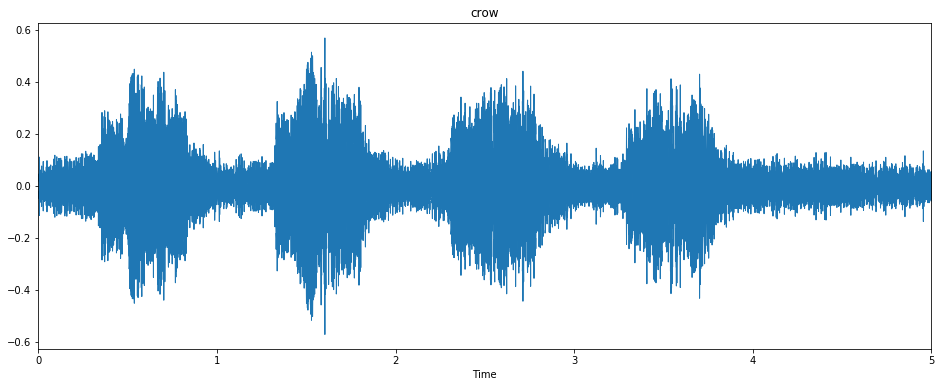

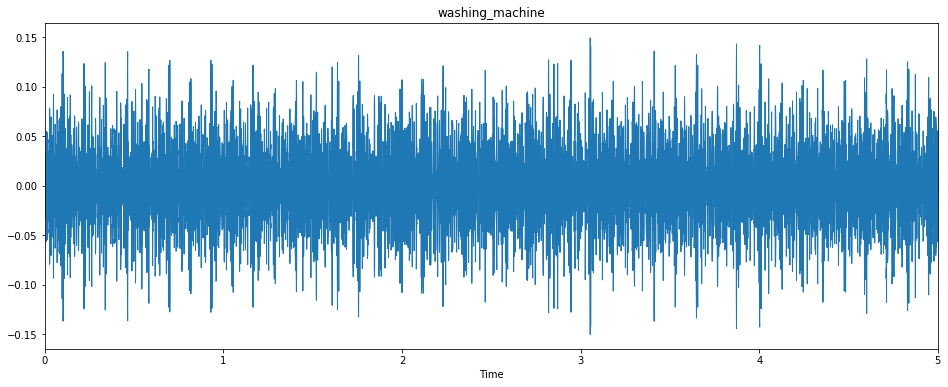

In [8]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
ldis.waveplot(y0, sr0)
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
ldis.waveplot(y1, sr1)

# Lowpass Filter

In [9]:
import scipy.signal as signal

def lowpass(y, N=3, Wn=0.5):
    # First, design the Buterworth filter
    N  = 3    # Filter order
    Wn = 0.5 # Cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    return signal.filtfilt(B,A, y)

In [10]:
y0 = lowpass(y0)
y1 = lowpass(y1)

/usr/local/lib/python3.5/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


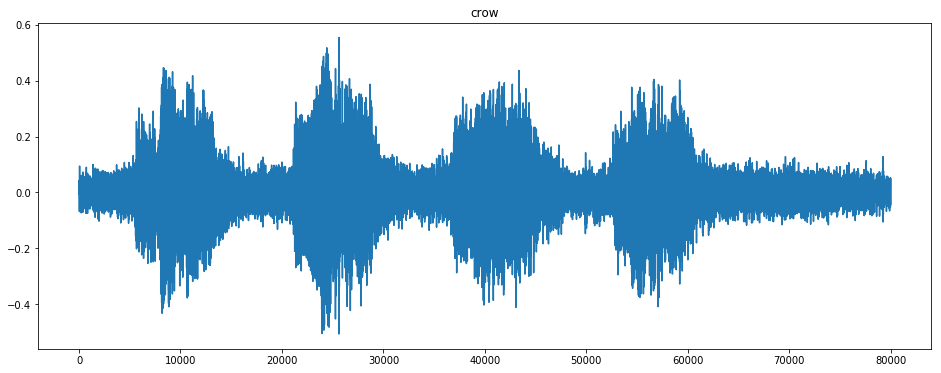

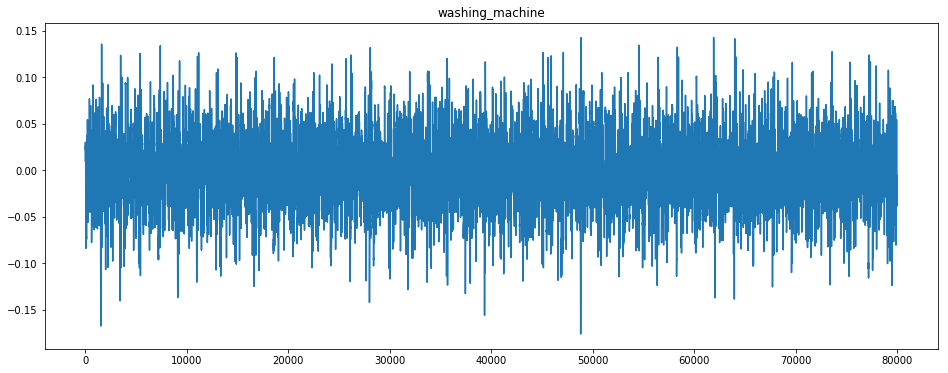

In [11]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
plt.plot(y0)
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
plt.plot(y1)

## Split
Split signal into non-silent intervals

In [12]:
def tokenize(y, blocksize, offset):
    y = np.array([y[i[0]:i[1]] for i in libr.effects.split(y, frame_length=512, hop_length=256, top_db=30)])
    
    out_y = np.zeros((blocksize,1))

    for i in range(0,len(y)):
        samplen = len(y[i])
        if samplen > blocksize:
            tmp_y = libr.util.frame(np.ascontiguousarray(y[i]), frame_length=blocksize, hop_length=offset)
            out_y = np.append(out_y, tmp_y, axis=1)
        elif samplen < blocksize:
            diff = blocksize-samplen
            padded = np.pad(y[i], (int(np.ceil(diff/2)),int(np.floor(diff/2))), 'edge')[:, np.newaxis]
            out_y = np.append(out_y, padded, axis=1)
        else:
            out_y = np.append(out_y, (y[i])[:,np.newaxis], axis=1)
    return out_y.T[1:]

In [13]:
y0 = tokenize(y0, blocksize, offset)

y1 = tokenize(y1, blocksize, offset)

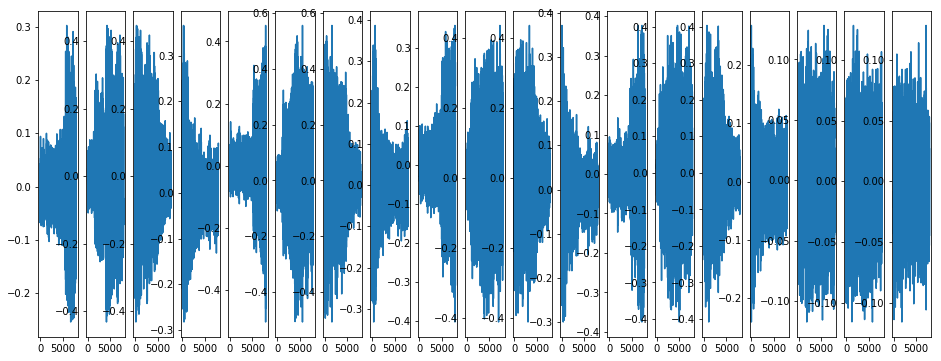

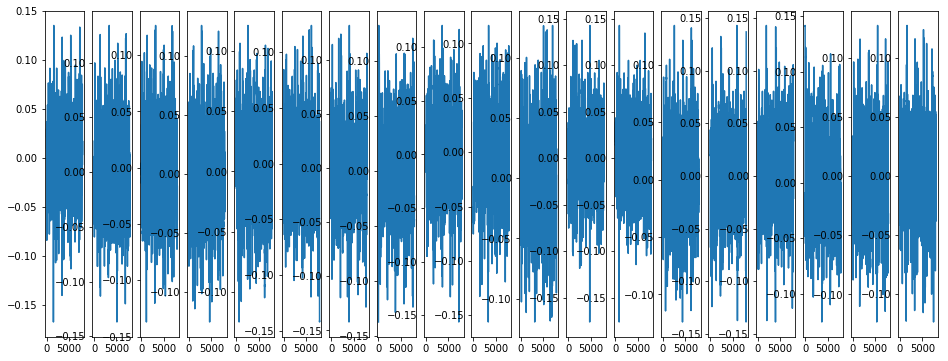

In [14]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
for i in range(0, len(y0)):
    ax=plt.subplot(1,len(y0),i+1)
    plt.plot(y0[i])

plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
for i in range(0, len(y1)):
    ax=plt.subplot(1,len(y1),i+1)
    plt.plot(y1[i])

## Normalize Signal
Normalize to between 0 and 1

In [15]:
for i in range(0, len(y0)):
    y0[i] /= np.max(y0[i], axis=0)
for i in range(0, len(y1)):
    y1[i] /= np.max(y1[i], axis=0)

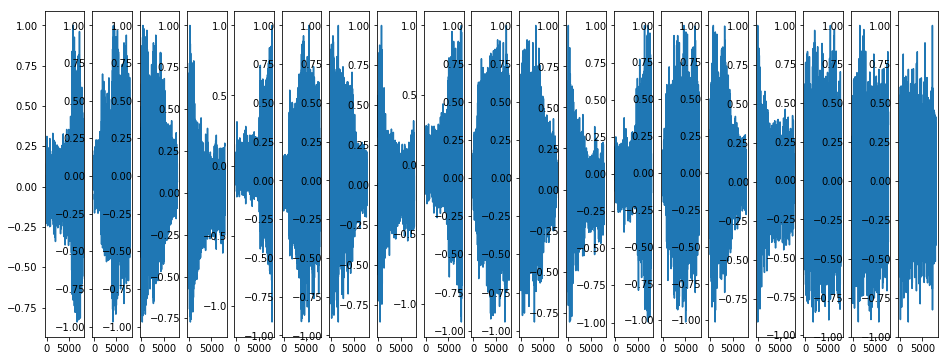

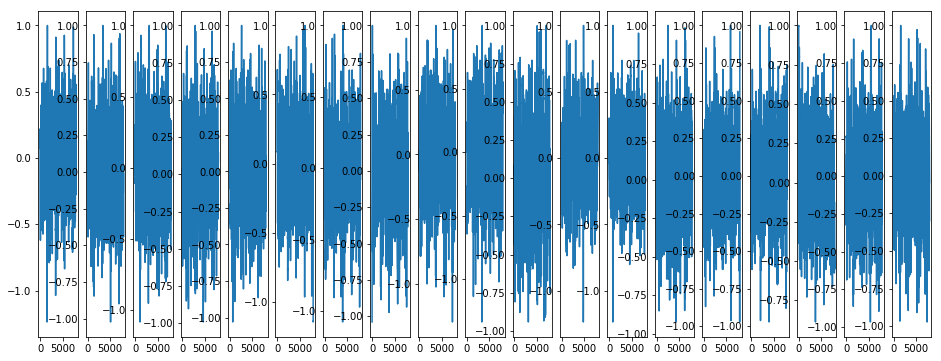

In [16]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
for i in range(0, len(y0)):
    ax=plt.subplot(1,len(y0),i+1)
    plt.plot(y0[i])

plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
for i in range(0, len(y1)):
    ax=plt.subplot(1,len(y1),i+1)
    plt.plot(y1[i])

### Onset Based Splitting
First needs spectrogram representation

In [17]:
# def splitter(sr=22050, y=None, S=None, hop_length=512, backtrack=True):
#     if S is None:
#         onset_samples = libr.onset.onset_detect(y, units='samples', sr=sr, hop_length=hop_length, backtrack=backtrack)
#     else:
#         onset_strength = libr.onset.onset_strength(S=S, sr=sr)
# #         print(onset_strength)
#         times = libr.frames_to_time(np.arange(len(onset_strength)), sr=sr)
# #         print(times)
#         onset_samples = libr.onset.onset_detect(onset_envelope=onset_strength, units='frames', sr=sr, hop_length=hop_length, backtrack=backtrack)
#     return onset_samples

In [18]:
# y0_orig = []
# t=0
# for i in splitter(y=y0, sr=sr0, hop_length=1024):
#     if y0[t:i].size:
#         y0_orig.append(y0[t:i])
#     t=i

# y1_orig = []
# t=0
# for i in splitter(y=y1, sr=sr1, hop_length=1024):
#     if y1[t:i].size:
#         y1_orig.append(y1[t:i])
#     t=i

In [19]:
# plt.figure(figsize=global_figsize)
# plt.title(samples.iloc[0]['category'])
# for i in range(0, len(y0_orig)):
#     ax=plt.subplot(1,len(y0_orig),i+1)
#     ldis.waveplot(y0_orig[i], sr0)

# plt.figure(figsize=global_figsize)
# plt.title(samples.iloc[1]['category'])
# for i in range(0, len(y1_orig)):
#     ax=plt.subplot(1,len(y1_orig),i+1)
#     ldis.waveplot(y1_orig[i], sr1)

## Halfwave Rectification
Only keep positive parts of signal

In [20]:
for i in range(0, len(y0)):
    y0[i] = y0[i].clip(min=0)
for i in range(0, len(y1)):
    y1[i] = y1[i].clip(min=0)

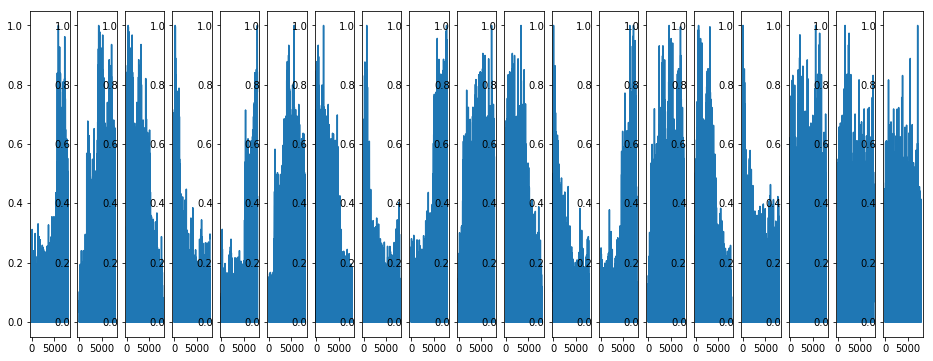

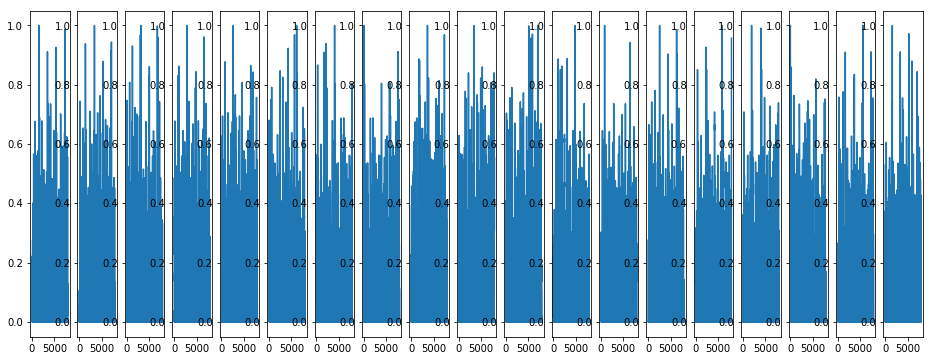

In [21]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
for i in range(0, len(y0)):
    ax=plt.subplot(1,len(y0),i+1)
    plt.plot(y0[i])

plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
for i in range(0, len(y1)):
    ax=plt.subplot(1,len(y1),i+1)
    plt.plot(y1[i])

## Filterbanks
A number of filterbanks are used throughout audio analytics and here we will compare them.

In [22]:
y0 = (y0[:,np.newaxis,:])
y1 = (y1[:,np.newaxis,:])

In [23]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
from kapre.utils import Normalization2D

Using TensorFlow backend.


In [24]:
print(y1.shape)
print(y0.shape)

(19, 1, 8000)
(19, 1, 8000)


In [25]:
def mel_spec_model(input_shape, n_mels, power_melgram, decibel_gram, sr, n_dft=128):
    model = Sequential()
    model.add(Melspectrogram(
        sr=sr,
        n_dft=n_dft,
        n_mels=n_mels,
        power_melgram=power_melgram,
        return_decibel_melgram = decibel_gram,
        input_shape=input_shape,
        trainable_fb=False
    ))
    model.add(Normalization2D(str_axis='channel'))
    return model

def spec_model(input_shape, decibel_gram):
    model = Sequential()
    model.add(Spectrogram(
        return_decibel_spectrogram = decibel_gram,
        input_shape=input_shape,
        n_dft=128
    ))
    model.add(Normalization2D(str_axis='channel'))
    return model

def check_model(model, debug=False):
    if debug:
        model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, sr, kind='linear', logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]

    if(kind == 'mel'):
        ldis.specshow(libr.amplitude_to_db(result, ref=np.max), x_axis='frames', y_axis='mel')
    else:
        ldis.specshow(result, y_axis=kind, fmin=800, fmax=8000, sr=sr)

def eval_single_model(model, src, sr):
    n_ch, nsp_src = model.input_shape[1:]
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    return result
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#         result = np.swapaxes(result, 1, 2)
#         print(result.shape)
    return result.clip(min=0)

### Unfiltered Spectrum

good
Epoch 1/1
2/2 [==============================] - 0s 54ms/step - loss: 1.3265
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 49ms/step - loss: 1.3410
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 55ms/step - loss: 1.3371
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 59ms/step - loss: 1.3336
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 69ms/step - loss: 1.3395
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 69ms/step - loss: 1.3316
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 72ms/step - loss: 1.3399
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 77ms/step - loss: 1.3314
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 80ms/step - loss: 1.3334
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 88ms/step - loss: 1.3320
(1, 8000)
good
Epoch 1/1
2/2 [==============================] - 0s 92ms/step - loss: 1.335

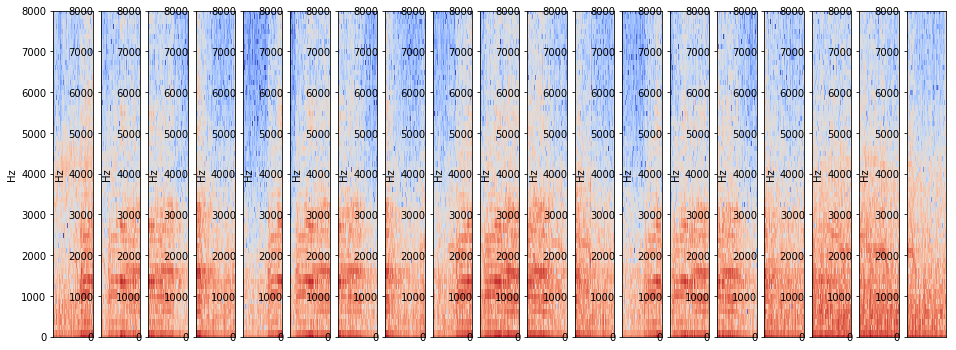

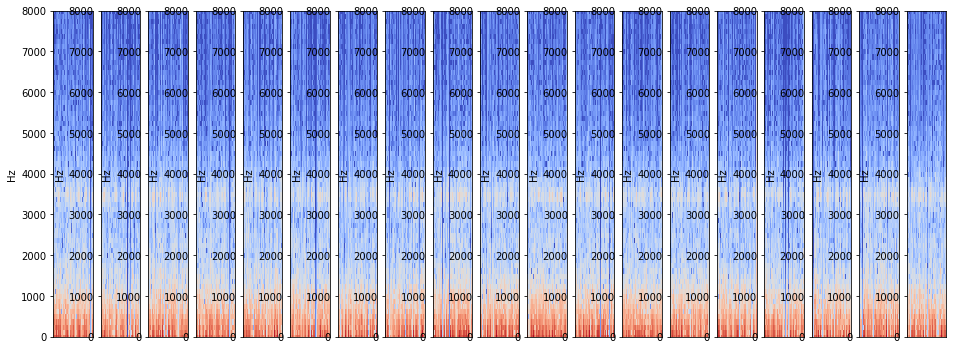

In [26]:
plt.figure(figsize=global_figsize)
for i in range(0, len(y0)):
    if(len(y0[i].shape) < 2):
        print(y0[i].shape)
        y0[i] = y0[i][:,np.newaxis]
        print(y0[i].shape)
    else:
        print('good')
    model = spec_model(input_shape=y0[i].shape, decibel_gram=True)
    check_model(model)
    ax=plt.subplot(1,len(y0),i+1)
    visualise_model(model, sr=sr0, src=y0[i])

plt.figure(figsize=global_figsize)
for i in range(0, len(y1)):
    model = spec_model(input_shape=y1[i].shape, decibel_gram=True)
    check_model(model)
    ax=plt.subplot(1,len(y1),i+1)
    visualise_model(model, sr=sr1, src=y1[i])

### Mel Filter
The popular mel filterbank

/usr/local/lib/python3.5/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


Epoch 1/1
2/2 [==============================] - 1s 263ms/step - loss: 1.3342
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 266ms/step - loss: 1.3316
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 277ms/step - loss: 1.3334
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 281ms/step - loss: 1.3318
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 285ms/step - loss: 1.3295
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 303ms/step - loss: 1.3334
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 307ms/step - loss: 1.3306
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 313ms/step - loss: 1.3320
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 322ms/step - loss: 1.3336
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 324ms/step - loss: 1.3340
(1, 8000)
Epoch 1/1
2/2 [==============================] - 1s 330ms/step - loss: 1.3300
(1, 8000)
Epoch 1/1
2/2 [=================

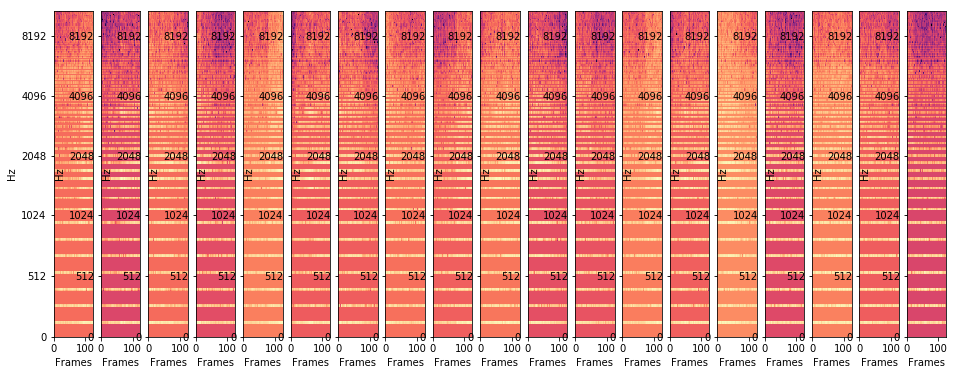

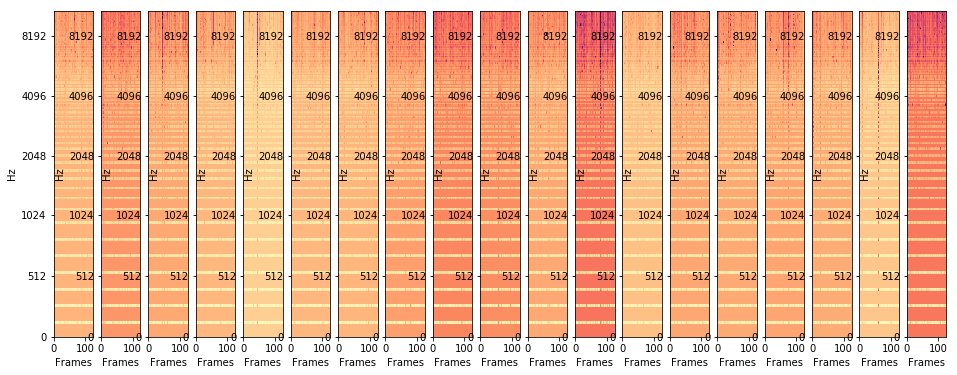

In [27]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
n_mels = 256
for i in range(0, len(y0)):
    mel_model = mel_spec_model(y0[i].shape, n_mels, True, True, sr0)
    check_model(mel_model)
    ax=plt.subplot(1,len(y0),i+1)
    visualise_model(mel_model, y0[i], sr=sr0, kind='mel')
    
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
for i in range(0, len(y1)):
    mel_model = mel_spec_model(y1[i].shape, n_mels, True, True, sr1)
    check_model(mel_model)
    ax=plt.subplot(1,len(y1),i+1)
    visualise_model(mel_model, y1[i], sr=sr1, kind='mel')

### Gammatone 
For more humanlike hearing

In [28]:
from gammatone import gtgram, fftweight, filters
import matplotlib

In [29]:
class ERBFormatter(matplotlib.ticker.EngFormatter):
    """
    Axis formatter for gammatone filterbank analysis. This formatter calculates
    the ERB spaced frequencies used for analysis, and renders them similarly to
    the engineering axis formatter.
    The scale is changed so that `[0, 1]` corresponds to ERB spaced frequencies
    from ``high_freq`` to ``low_freq`` (note the reversal). It should be used
    with ``imshow`` where the ``extent`` argument is ``[a, b, 1, 0]`` (again,
    note the inversion).
    """

    def __init__(self, low_freq, high_freq, *args, **kwargs):
        """
        Creates a new :class ERBFormatter: for use with ``matplotlib`` plots.
        Note that this class does not supply the ``units`` or ``places``
        arguments; typically these would be ``'Hz'`` and ``0``.
        :param low_freq: the low end of the gammatone filterbank frequency range
        :param high_freq: the high end of the gammatone filterbank frequency
          range
        """
        self.low_freq = low_freq
        self.high_freq = high_freq
        super().__init__(*args, **kwargs)

    def _erb_axis_scale(self, fraction):
        return filters.erb_point(self.low_freq, self.high_freq, fraction)

    def __call__(self, val, pos=None):
        newval = self._erb_axis_scale(val)
        return super().__call__(newval, pos)

def gtgram_plot(
        gtgram_function,
        axes, x, fs, window_time, 
        hop_time, channels, f_min
        ):
    """
    Plots a spectrogram-like time frequency magnitude array based on gammatone
    subband filters.
    :param gtgram_function: A function with signature::
        fft_gtgram(
            wave,
            fs,
            window_time, hop_time,
            channels,
            f_min)
    See :func:`gammatone.gtgram.gtgram` for details of the paramters.
    """
    # Set a nice formatter for the y-axis
    formatter = ERBFormatter(f_min, fs/2, unit='Hz', places=0)
    axes.yaxis.set_major_formatter(formatter)

    # Figure out time axis scaling
    duration = len(x) / fs

    # Calculate 1:1 aspect ratio
    golden = (1 + 5 ** 0.5) / 2
    aspect_ratio = duration/golden

    gtg = gtgram_function(x, fs, window_time, hop_time, channels, f_min)
    Z = np.flipud(20 * np.log10(gtg))

    img = axes.imshow(Z, extent=[0, duration, 1, 0], aspect=aspect_ratio)

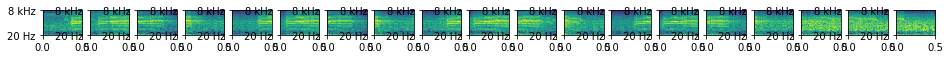

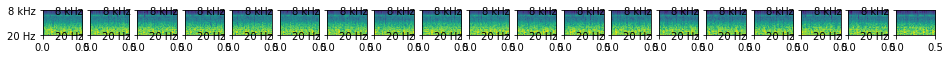

In [30]:
plt.figure(figsize=global_figsize)
plt.title(samples.iloc[0]['category'])
for i in range(0, len(y0)):
    ax=plt.subplot(1,len(y0),i+1)
    gtgram_plot(gtgram.gtgram, ax, y0[i][0][:], sr0, 0.01, 0.005, 2048, 20)

plt.figure(figsize=global_figsize)
plt.title(samples.iloc[1]['category'])
for i in range(0, len(y1)):
    ax=plt.subplot(1,len(y1),i+1)
    gtgram_plot(gtgram.gtgram, ax, y1[i][0][:], sr1, 0.01, 0.005, 2048, 20)

# Full Dataset
Now we get these representations for the whole dataset

## Mel Retreival

In [31]:
start_t = time.time()
yy = []
zcr = []
testset = dataset[:10]
for j in range(0,len(testset)):
    # Load audio with downsample to 16000
    y, sr = libr.core.load('../ESC-50/audio/' + testset.iloc[j]['filename'], sr=16000, mono=True)
    zcr.append(libr.feature.zero_crossing_rate(y))
    y = lowpass(y)
    # Normalize signal
    y /= np.max(y, axis=0)
    # Half-wave rectify
    y = y.clip(min=0)
    y = tokenize(y, blocksize, offset)

    yy.append(y[:, np.newaxis, :])

/usr/local/lib/python3.5/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [34]:
print(len(zcr))

10


In [ ]:
mel_model = mel_spec_model(yy[0][0].shape, power_melgram=True, decibel_gram=False, sr=sr, n_mels=256, n_dft=1024)
check_model(mel_model)

Epoch 1/1
2/2 [==============================] - 1s 532ms/step - loss: 1.3243


In [ ]:
mels = []
for i in range(0, len(yy)):
    mels.append(evaluate_model(mel_model, yy[i]))

In [ ]:
testset['mel'] = mels
testset['zcr'] = zcr
end_t = time.time()

In [ ]:
m, s = divmod(end_t-start_t, 60)
h, m = divmod(m, 60)
print('{:f}:{:02f}:{:02f}'.format(h, m, s)) # Python 3

0.000000:6.000000:21.129472


# Feature Extract

In [ ]:
# Returns the standard deviation of the data, the mean of the data, and the noise calculated from mean and stddev
def std_dev_mean_noise(data):
    # Standard deviation of data
    stddev = np.std(data, axis=1)
    mean = np.mean(data, axis=1)
    sig_noise = mean / stddev
    ret_dat = np.hstack((stddev, mean, sig_noise))
    return ret_dat

def extract_features(f, target, h_target):
    items=[]
    for (i, S_i) in enumerate(f):
        mfccs = libr.feature.mfcc(S=libr.power_to_db(S_i), n_mfcc=13)
        # First derivatives
        delta = libr.feature.delta(mfccs)
        # Second Deriv
        delta_2 = libr.feature.delta(mfccs, order=2)
        # Spectral Centroid
        cent = libr.feature.spectral_centroid(S=S_i)
        # Spectral Bandwidth
        band = libr.feature.spectral_bandwidth(S=S_i)
        # Spectral Flatness
        flat = libr.feature.spectral_flatness(S=S_i)
        # Spectral rolloff
        roll = libr.feature.spectral_rolloff(S=S_i)
        # RMSE
        rmse = libr.feature.rmse(S=S_i)
        
        dat = np.vstack((mfccs[1:], delta, delta_2, cent, band, flat, roll, rmse))
        # Reduce to single feature row
        dat = std_dev_mean_noise(dat)
        dat = np.hstack((
            target,
            h_target,
            dat
        ))
        items.append(dat)

    return items

In [ ]:
start_t = time.time()

columns = [
            'target', 'h_target',
            'mfcc_2_std', 'mfcc_2_mean', 'mfcc_2_noise',
            'mfcc_3_std', 'mfcc_3_mean', 'mfcc_3_noise',
            'mfcc_4_std', 'mfcc_4_mean', 'mfcc_4_noise',
            'mfcc_5_std', 'mfcc_5_mean', 'mfcc_5_noise',
            'mfcc_6_std', 'mfcc_6_mean', 'mfcc_6_noise',
            'mfcc_7_std', 'mfcc_7_mean', 'mfcc_7_noise',
            'mfcc_8_std', 'mfcc_8_mean', 'mfcc_8_noise',
            'mfcc_9_std', 'mfcc_9_mean', 'mfcc_9_noise',
            'mfcc_10_std', 'mfcc_10_mean', 'mfcc_10_noise',
            'mfcc_11_std', 'mfcc_11_mean', 'mfcc_11_noise',
            'mfcc_12_std', 'mfcc_12_mean', 'mfcc_12_noise',
            'mfcc_13_std', 'mfcc_13_mean', 'mfcc_13_noise',
            'mfcc_1_p_std', 'mfcc_1_p_mean', 'mfcc_1_p_noise',
            'mfcc_2_p_std', 'mfcc_2_p_mean', 'mfcc_2_p_noise',
            'mfcc_3_p_std', 'mfcc_3_p_mean', 'mfcc_3_p_noise',
            'mfcc_4_p_std', 'mfcc_4_p_mean', 'mfcc_4_p_noise',
            'mfcc_5_p_std', 'mfcc_5_p_mean', 'mfcc_5_p_noise',
            'mfcc_6_p_std', 'mfcc_6_p_mean', 'mfcc_6_p_noise',
            'mfcc_7_p_std', 'mfcc_7_p_mean', 'mfcc_7_p_noise',
            'mfcc_8_p_std', 'mfcc_8_p_mean', 'mfcc_8_p_noise',
            'mfcc_9_p_std', 'mfcc_9_p_mean', 'mfcc_9_p_noise',
            'mfcc_10_p_std', 'mfcc_10_p_mean', 'mfcc_10_p_noise',
            'mfcc_11_p_std', 'mfcc_11_p_mean', 'mfcc_11_p_noise',
            'mfcc_12_p_std', 'mfcc_12_p_mean', 'mfcc_12_p_noise',
            'mfcc_13_p_std', 'mfcc_13_p_mean', 'mfcc_13_p_noise',
            'mfcc_1_pp_std', 'mfcc_1_pp_mean', 'mfcc_1_pp_noise',
            'mfcc_2_pp_std', 'mfcc_2_pp_mean', 'mfcc_2_pp_noise',
            'mfcc_3_pp_std', 'mfcc_3_pp_mean', 'mfcc_3_pp_noise',
            'mfcc_4_pp_std', 'mfcc_4_pp_mean', 'mfcc_4_pp_noise',
            'mfcc_5_pp_std', 'mfcc_5_pp_mean', 'mfcc_5_pp_noise',
            'mfcc_6_pp_std', 'mfcc_6_pp_mean', 'mfcc_6_pp_noise',
            'mfcc_7_pp_std', 'mfcc_7_pp_mean', 'mfcc_7_pp_noise',
            'mfcc_8_pp_std', 'mfcc_8_pp_mean', 'mfcc_8_pp_noise',
            'mfcc_9_pp_std', 'mfcc_9_pp_mean', 'mfcc_9_pp_noise',
            'mfcc_10_pp_std', 'mfcc_10_pp_mean', 'mfcc_10_pp_noise',
            'mfcc_11_pp_std', 'mfcc_11_pp_mean', 'mfcc_11_pp_noise',
            'mfcc_12_pp_std', 'mfcc_12_pp_mean', 'mfcc_12_pp_noise',
            'mfcc_13_pp_std', 'mfcc_13_pp_mean', 'mfcc_13_pp_noise',
            'scen_std', 'scen_mean', 'scen_noise',
            'sband_std', 'sband_mean', 'sband_noise',
            'sflat_std', 'sflat_mean', 'sflat_noise',
            'sroll_std', 'sroll_mean', 'sroll_noise',
            'rmse_std', 'rmse_mean', 'rmse_noise',
          ]
splits = []
for (i, mel) in enumerate(testset['mel']):
    splits += extract_features(mel, testset.iloc[i]['target'], testset.iloc[i]['h_target'])

features = pd.DataFrame(splits, columns=columns)
end_t = time.time()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
m, s = divmod(end_t-start_t, 60)
h, m = divmod(m, 60)
print('{:f}:{:02f}:{:02f}'.format(h, m, s)) # Python 3

0.000000:1.000000:7.980637


In [ ]:
features = features.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=0)
features.describe()

,target,h_target,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,...,sband_noise,sflat_std,sflat_mean,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise
count,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,...,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000,30793.000000
mean,24.939727,0.655084,61.489753,48.419676,38.280753,31.832448,28.870636,27.878087,27.311030,26.335708,...,0.080108,0.079004,0.067872,0.060904,0.059886,5.155167,6.867899,1.066046,8.775132,2.705896
std,14.393617,0.475349,38.086579,27.603939,17.451170,13.384762,11.937642,11.758889,12.363778,12.190600,...,0.552291,0.545419,0.541867,0.533704,0.536226,5.498674,14.097220,0.706596,35.344690,2.991770
min,0.000000,0.000000,0.631814,0.255326,0.446490,0.302159,0.011784,0.092013,0.219750,0.162296,...,-5.765449,-6.389999,-5.823634,-4.068450,-3.475762,0.258199,0.258199,0.258199,0.258199,0.258199
25%,12.000000,0.000000,34.266799,27.616964,26.319245,22.940327,20.952421,19.971551,18.983551,18.077278,...,-0.290208,-0.292344,-0.305543,-0.309920,-0.315138,0.885413,0.920424,0.572016,0.885716,0.997975
50%,25.000000,1.000000,50.101206,42.683598,36.667707,30.927241,27.854029,26.639932,25.749108,24.858940,...,0.111677,0.103210,0.086944,0.082698,0.070041,3.428867,3.840619,0.881917,3.109533,1.919580
75%,38.000000,1.000000,80.924132,64.545449,48.606670,39.472075,35.765162,34.458196,33.806763,32.544091,...,0.469313,0.463303,0.457167,0.444964,0.442817,7.509041,9.030869,1.396111,7.088974,3.532661
max,49.000000,1.000000,222.860991,179.565163,139.097112,116.859454,100.293759,101.521386,129.220121,117.266916,...,7.017280,4.237992,5.876735,4.719757,5.910539,66.517265,554.399703,31.407268,768.141697,83.409240


In [ ]:
# Save to csv
features.to_csv("peripheral_analyzer.csv")

# Feature Reduce

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
# Separate target and features
X = features.drop(['target', 'h_target'], axis=1)
y = features['target']

In [ ]:
# Use standard scaler
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=columns[2:])

In [ ]:
X.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sband_noise,sflat_std,sflat_mean,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise
0,0.960052,2.226433,1.005651,0.632129,-0.716366,0.177373,1.291394,1.379472,-0.179913,-0.009656,...,-1.011988,-1.005983,0.689530,0.480529,0.173244,-0.789445,-0.424792,-0.689650,-0.223508,-0.691330
1,-0.640087,-0.175902,0.189702,0.571835,0.603101,1.058465,0.564652,0.086049,1.019925,2.433658,...,-1.304626,-0.865183,0.146684,0.581545,1.499520,1.078740,1.115044,-0.794170,4.302030,-0.322307
2,-0.795599,-0.340565,0.146878,0.232502,0.927220,-0.371926,0.353936,-0.390088,1.062880,1.222784,...,0.944307,0.318308,-0.675964,-0.325640,0.110817,1.112166,0.792667,-0.826065,4.670887,-0.156558
3,-0.627661,-0.121360,0.399145,-0.433839,1.066435,0.627285,0.311250,0.091936,0.773930,0.730985,...,-0.814878,0.391777,-1.088601,0.006798,-1.379716,1.815574,0.740653,-0.966649,4.159945,-0.279822
4,-0.769491,0.732627,0.810264,0.331974,1.551189,1.980197,1.410720,1.378600,0.385649,1.826702,...,0.936056,-0.426173,-1.208476,-0.575927,-1.305039,0.117907,0.025372,-1.072077,0.298561,-0.525959


## PCA Reduction

In [ ]:
pca = PCA(n_components=50)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_X = pd.DataFrame(pca.transform(X))

In [ ]:
pca_X.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5.906003,-5.999315,-0.210355,0.486968,1.958456,2.196805,-1.136013,-1.642789,0.217304,0.348049,...,0.152020,1.985792,1.733643,-0.919408,0.543690,-0.118107,-0.519806,-0.247044,-0.068090,-0.758816
1,4.458329,4.294721,1.859189,-0.105996,0.194242,1.740584,3.647053,0.367170,2.590952,-1.215961,...,0.154668,1.535354,-3.464552,-0.954789,0.858661,-0.420050,0.380819,-0.305646,-0.062478,0.951959
2,3.083793,4.267388,1.363310,1.297277,2.362385,0.745440,3.246005,1.136797,3.061368,-0.842477,...,1.099638,1.123979,-3.532697,-1.288285,-1.395909,0.154128,-0.278690,0.187723,-0.439257,1.611944
3,2.287235,3.745908,2.591474,1.751645,2.383250,2.142877,2.620727,2.464807,2.251376,-1.819865,...,0.769199,2.008532,-2.621899,-0.766080,-0.441794,0.469586,-0.389682,0.373008,0.305851,0.133609
4,5.934254,2.842423,2.171086,-0.157343,-2.318753,2.591688,2.374938,0.590115,-2.017816,-1.823099,...,0.786502,1.593228,0.291071,0.738659,-0.700780,1.849853,-0.406552,1.730377,0.945438,0.214468


In [ ]:
pca_X['target'] = list(y.astype(int))
pca_X.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,5.906003,-5.999315,-0.210355,0.486968,1.958456,2.196805,-1.136013,-1.642789,0.217304,0.348049,...,1.985792,1.733643,-0.919408,0.543690,-0.118107,-0.519806,-0.247044,-0.068090,-0.758816,0
1,4.458329,4.294721,1.859189,-0.105996,0.194242,1.740584,3.647053,0.367170,2.590952,-1.215961,...,1.535354,-3.464552,-0.954789,0.858661,-0.420050,0.380819,-0.305646,-0.062478,0.951959,14
2,3.083793,4.267388,1.363310,1.297277,2.362385,0.745440,3.246005,1.136797,3.061368,-0.842477,...,1.123979,-3.532697,-1.288285,-1.395909,0.154128,-0.278690,0.187723,-0.439257,1.611944,14
3,2.287235,3.745908,2.591474,1.751645,2.383250,2.142877,2.620727,2.464807,2.251376,-1.819865,...,2.008532,-2.621899,-0.766080,-0.441794,0.469586,-0.389682,0.373008,0.305851,0.133609,14
4,5.934254,2.842423,2.171086,-0.157343,-2.318753,2.591688,2.374938,0.590115,-2.017816,-1.823099,...,1.593228,0.291071,0.738659,-0.700780,1.849853,-0.406552,1.730377,0.945438,0.214468,14


In [ ]:
sns.pairplot(data=pca_X, hue='target', vars=pca_X.columns[:-1])

KeyboardInterrupt: 

## Feature Select K Best

In [ ]:
feat_select = SelectKBest(chi2, k=50)
feat_select.fit(np.abs(X),y)

In [ ]:
idx_list = feat_select.get_support(indices=True)
print([columns[i+2] for i in idx_list])

In [ ]:
feat_X = pd.DataFrame(feat_select.transform(np.abs(X)), columns=[columns[i+2] for i in idx_list])

In [ ]:
feat_X['target'] = list(y.astype(int))
feat_X.head()

In [ ]:
sns.pairplot(data=feat_X, hue='target', vars=feat_X.columns[:-1])

## LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=5)
lda.fit(X,y=y)

In [ ]:
lda_X = pd.DataFrame(lda.transform(X))

In [ ]:
lda_X['target'] = list(y.astype(int))
lda_X.head()

In [ ]:
sns.pairplot(data=lda_X, hue='target', vars=lda_X.columns[:-1])